# Quantum Convolutional Neural Network
Here we present an attempt to do entanglement detection via a Quantum convolutional neural network (QCNN)
The structure of the network is similar to that of a classical Convolutional neural network (CNN), expect for an initial layer where a feature mapping is performed in order to embedd classical data into quantum states.  

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


#from qiskit.extensions import UnitaryGate
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, AQGD, GradientDescent, ADAM
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import Operator
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes, EfficientSU2, PauliFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
#import qiskit.quantum_info as qi

# 1. Trial with the states (amplitude's square module)

## Dataset
We import the dataset "ds_haar_op.csv", which contains 4x4 unitary matrices sampled according to the Haar measure.    
From each of these matrices we extract the first row, which is a normalized two-qubits state. 
Finally we perform the square module of each amplitudes and create the dataset where each example is characterized by:  
1. Four features, each one being a probability
2. The target, which can be either 0 (entangled state) or 1 (separable state)

In [6]:
#Importing the dataset
df = pd.read_csv('../datasets/ds_haar_op.csv')
df = df[:200]

#Verify if the dataset is balanced
count_0 = 0
count_1 = 0
for i in range(len(df)):
    if df.iloc[i,16] == True:
        count_1 += 1
    else:
        count_0 += 1
print("Sep:", count_1)
print("Ent:", count_0)

#Separate between features and target
X = df.drop(columns = ["sep"])
y = df.iloc[:,16]
X = np.asarray(X, dtype = np.cdouble)
y = np.asarray(y, dtype = np.int32)

#Getting the new features as square modules of th eamplitudes of the selected states (already normalized)
states = []
for i in range(len(X)):
    u_matrix=X[i].reshape(4,4)
    state_probs = [np.abs(u_matrix[0][k])**2 for k in range(4)]
    states.append(state_probs)
states = np.asarray(states, dtype=np.double)
states

#Split between train and test sets
X_train, X_test, y_train, y_test = train_test_split(states, y, test_size = 0.2)


Sep: 108
Ent: 92


## Circuit and training - test
Now we construct the convolutional circuit.  
As has been said in the introduction, it consists of an alternating series of convolutional and pooling layers. The aim of such neural network is to progressively reduce the dimension of the circuit (i.e. reduce the number of qubits which the subsequent gates are appplied to) while retaining as much information as possible. 

We firstly define the quantum circuit that implements the convolutional layers as a sequence of rz and ry rotations, together with cnot gates.

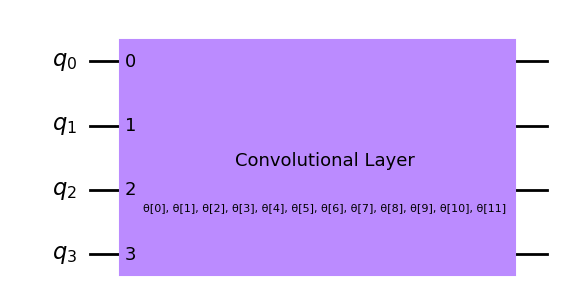

In [7]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
#circuit.draw("mpl", style="clifford")


def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.draw("mpl", style="clifford")

Similarly we do for the pooling layer.

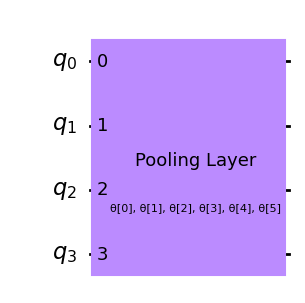

In [8]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("phi", length=3)
circuit = pool_circuit(params)
#circuit.draw("mpl", style="clifford")

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.draw("mpl", style="clifford")

Finally we assembly the whole circuit by firstly applying a feature map (here we have chosen the ZZFeatureMap contained in qiskit) that embedds the classical inputs into quantum ones. Then we apply twice one convolutional layer followed by a pooling layer. At the end we measure the fourth qubit with the $\hat I\otimes\hat I\otimes\hat I\otimes\hat Z$ operator.

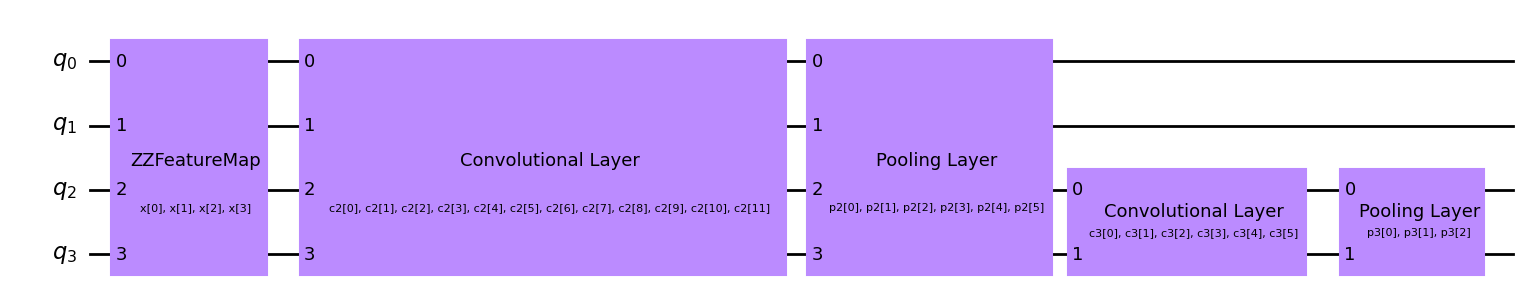

In [9]:
feature_map = ZZFeatureMap(4)

ansatz = QuantumCircuit(4, name="Ansatz")

# First Convolutional Layer
#ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
#ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(2,4)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(2,4)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(4)
circuit.compose(feature_map, range(4), inplace=True)
circuit.compose(ansatz, range(4), inplace=True)

observable = SparsePauliOp.from_list([("I"*3 + "Z", 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl", style="clifford")

We define then a callback function, to be called at the end of each iteration of the NN, that draws the trend of the objective function (which in our case is the loss function).

In [10]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

So we initialize our QCNN class passing the previous circuit and choosing the COBYLA optimizer.  

Then we train our model.

In [13]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=75),  # Set max iterations here
    callback=callback_graph,
)

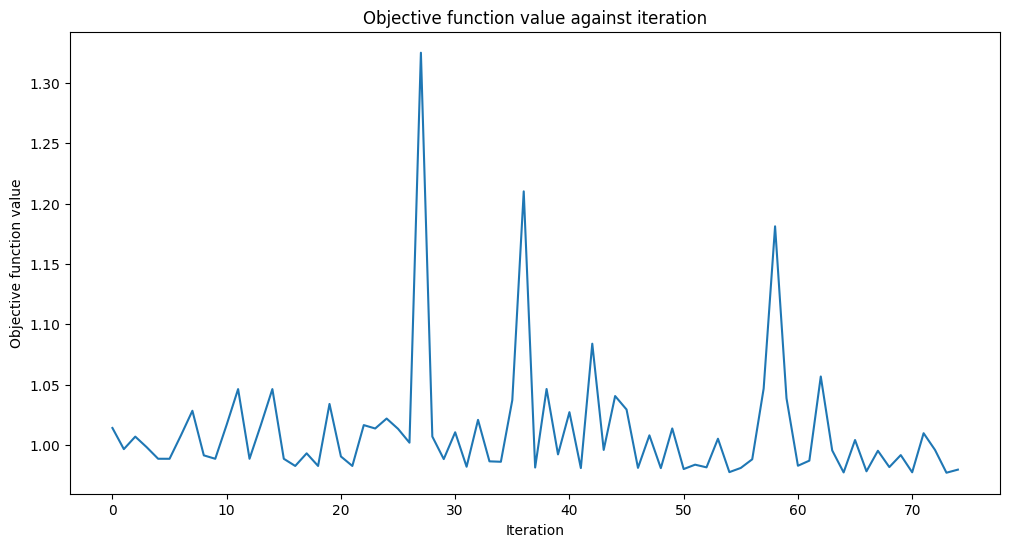

Accuracy from the train data : 53.33%
Accuracy from the test data : 55.0%


In [24]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train, y_train)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(X_train, y_train), 2)}%")

print(f"Accuracy from the test data : {np.round(100 * classifier.score(X_test, y_test), 2)}%")

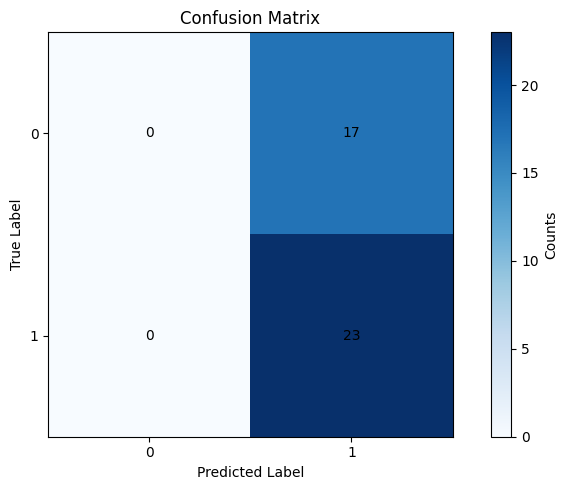

In [16]:
predicted = classifier.predict(X_test)


from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# Add labels
plt.title('Confusion Matrix')
plt.xticks(np.arange(2), ['0', '1']) # Set x-axis ticks
plt.yticks(np.arange(2), ['0', '1']) # Set y-axis ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar(label='Counts')


# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')


plt.tight_layout()
plt.show()


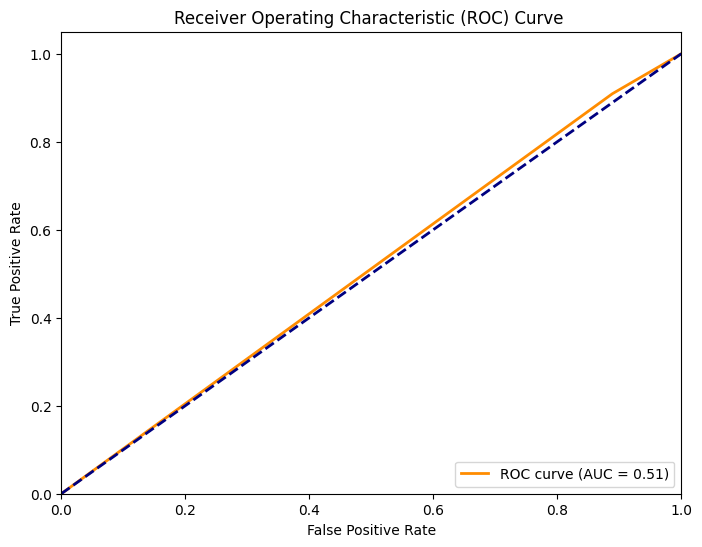

In [26]:
from sklearn.metrics import roc_curve, auc


pred_test_prob = classifier.predict(X_test)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_test_prob)

# Calculate Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve ')
plt.legend(loc='lower right')
plt.show()


The loss function starts to converge after the $\approx 100^{th}$ iteration, but the accuracies of the training and test sets are pretty small, and we note that the accuracy of the test set is higher than that of the training set. This is a signal that something is not working as it should.

# 2. Trial with the projections onto Bell states

## Dataset
We import the dataset "ds_mixed_obs.csv", which contains probabilities of successfully projecting a state onto a singlet
Bell state, given a particular pair of local projections; these probabilities are computed via collective measurements. (see Trávníček et al., "Sensitivity versus selectivity in entanglement detection via collective witnesses").  
The projected states are recovered form the dataset ""ds_mixed_op.csv", which contains the respective unitary matrices. 

The target says if the state is either separable (label 1) or entangled (label 0).

We take only the first hundred example and, as usual, we split them into training and test sets.

In [19]:
dataset = pd.read_csv("../datasets/ds_haar_obs.csv")
dataset = dataset[:200]

# Drop the 17th column
X = dataset.drop(columns=dataset.columns[10])

# Separate features (X) and labels (y)
y = dataset.iloc[:, 10]  # Assuming the label is in the 11th column (index 10)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Transform the feautre into angles
X_train = X_train.to_numpy()[:,0:4]
X_test = X_test.to_numpy()[:,0:4]
y_train = np.array(y_train.to_numpy().astype(int)*2-np.ones(len(y_train)))
y_test = np.array(y_test.to_numpy().astype(int)*2-np.ones(len(y_test)))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(180, 4)
(20, 4)
(180,)
(20,)


## Circuit and training - test
We use the same circuit implemented previously, but obviusly we re-initialize our classifier, using the same optimizer.

In [20]:
classifier2 = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=75),  # Set max iterations here
    callback=callback_graph,
)

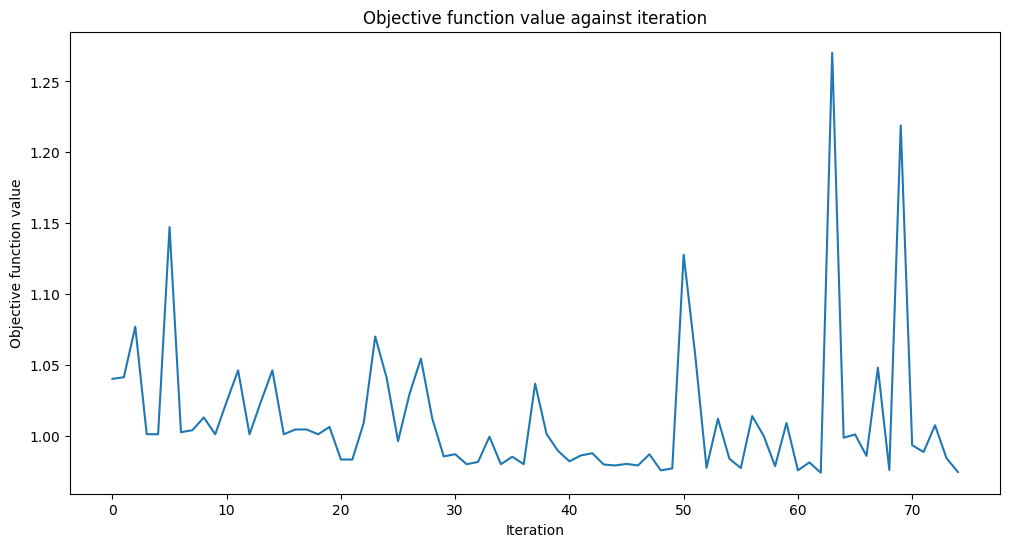

Accuracy from the train data : 55.0%


In [21]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier2.fit(X_train, y_train)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier2.score(X_train, y_train), 2)}%")

In [22]:
print(f"Accuracy from the test data : {np.round(100 * classifier.score(X_test, y_test), 2)}%")

Accuracy from the test data : 55.0%


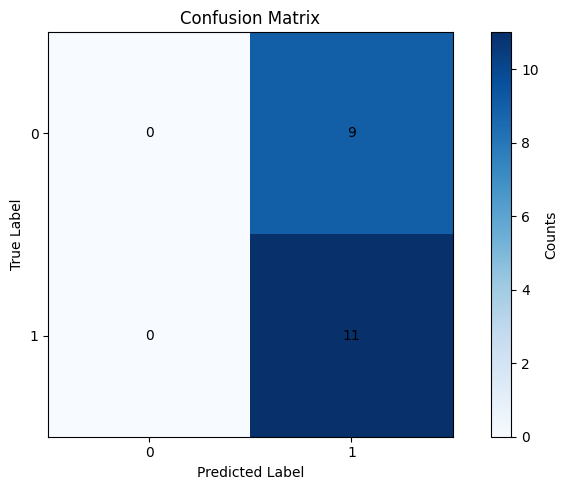

In [23]:
predicted = classifier.predict(X_test)


from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# Add labels
plt.title('Confusion Matrix')
plt.xticks(np.arange(2), ['0', '1']) # Set x-axis ticks
plt.yticks(np.arange(2), ['0', '1']) # Set y-axis ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar(label='Counts')


# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')


plt.tight_layout()
plt.show()


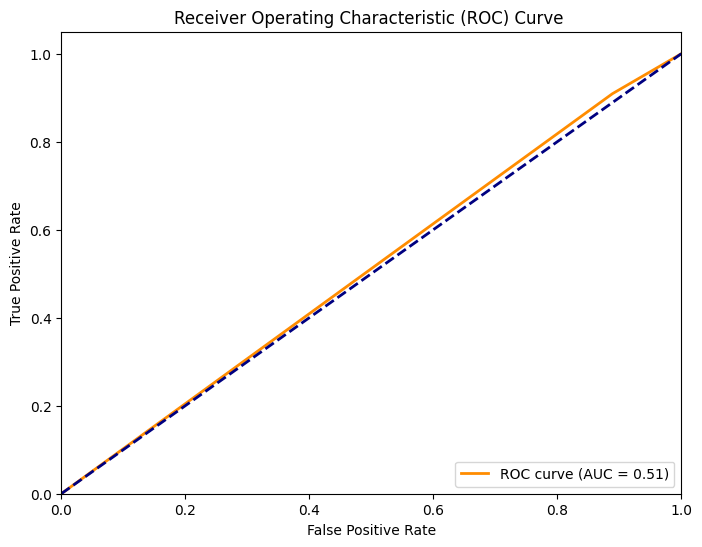

In [27]:
from sklearn.metrics import roc_curve, auc

predicted = classifier.predict(X_test)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# Calculate Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve ')
plt.legend(loc='lower right')
plt.show()


Though, as before, the loss function starts to converge after the $\approx 100^{th}$ iteration, the accuracy on the training set is pretty low, and that of the test set is even worse.  
